# MERRA 

## Imports 

In [2]:
import os
import awscli as aws
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
from datetime import time
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry

import matplotlib.pyplot as plt
import xarray 
import scipy.stats as ss 
import metpy  
import os
import h5py    
from pyhdf import SD
from mpl_toolkits.basemap import Basemap
import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import time
import calendar
from matplotlib.patches import Polygon
from netCDF4 import Dataset # Import the NetCDF Python interface
import netCDF4 as nc
import geopandas as gpd
from shapely.geometry import Point, Polygon
import bottleneck
import shapely
import dask
import nco
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from textwrap import wrap
import matplotlib.patches as mpatches
import matplotlib.gridspec as grd


from pyproj import _proj
from pyproj.utils import _convertback, _copytobuffer


/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# AOD 

## Load in AOD data

In [6]:
# create empty array to add into 
file_names_unsorted_merra = []

path = '/data2/edworak/data/merra2'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_merra.append(f)
file_names_merra = sorted(file_names_unsorted_merra)

print(len(file_names_unsorted_merra))
file_names_merra[0:4]

127


['MERRA2_401.inst3_2d_gas_Nx.20210601.nc4',
 'MERRA2_401.inst3_2d_gas_Nx.20210602.nc4',
 'MERRA2_401.inst3_2d_gas_Nx.20210603.nc4',
 'MERRA2_401.inst3_2d_gas_Nx.20210604.nc4']

In [4]:
goes_data_merra = []

for i in range(len(file_names_merra[:-1])):
    path = '/data2/edworak/data/merra2/'
    FILE = path + file_names_merra[i]
    #print(FILE)
    #"goes_"+ filename[i][30:36] = xarray.open_dataset(FILE)
    goes_data_merra = xarray.open_dataset(FILE)
goes_data_merra["AODANA"][:]

/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'AODANA' (time: 8, lat: 361, lon: 576)>
[1663488 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 2021-09-30 ... 2021-09-30T21:00:00
Attributes:
    long_name:       Aerosol Optical Depth Analysis
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   Aerosol Optical Depth Analysis
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

min : <xarray.DataArray 'AODANA' ()>
array(2.50416597e-05)
max : <xarray.DataArray 'AODANA' ()>
array(3.21361542)
2021 06 15


<xarray.DataArray 'lon' (lon: 576)>
array([-180.   , -179.375, -178.75 , ...,  178.125,  178.75 ,  179.375])
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    long_name:    longitude
    units:        degrees_east
    vmax:         1000000000000000.0
    vmin:         -1000000000000000.0
    valid_range:  [-1.e+15  1.e+15]

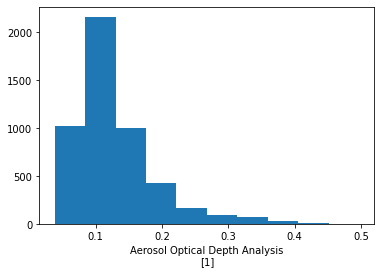

In [7]:
# AODANA : Aerosol Optical Depth Analysis
ds =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')
#ds['AODANA'][0,:,:].plot()
ds['AODANA'].sel(lat=slice(48,60),lon=slice(-125,-110)).plot()
#ds['T10M'].sel(lat=slice(0,50),lon=slice(55,115),time="1980-01-01T01:00:00").plot()

ds.time.begin_date
ds.AODANA.attrs
print("min : {}".format(ds["AODANA"][:].min()))
print("max : {}".format(ds["AODANA"][:].max()))

date = ds.AODANA.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]
print(year, month, day)
#goes_data_pyrocb.attrs["units"] = "celsius"
ds.AODANA.lon

## AOD Map 

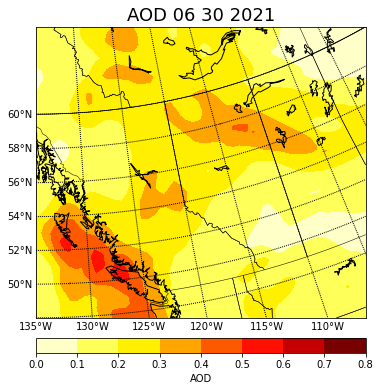

In [9]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210630.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]

# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon-180,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

#aod = map.contourf(x,y,np.squeeze(aodana[4,:,:]))

#cs = map.contourf(x,y,aodana[4,:,:], cmap = 'hot_r')

aod_mask_1 = np.ma.masked_greater(aodana,0.8)
aod_mask_2 = np.ma.masked_less(aod_mask_1,0)

im = map.contourf(x,y,aod_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='AOD', alpha = 0.8)
im.set_clim(0, 0.9)

# cbar.set_label(tmax_units)

date = nc.AODANA.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('AOD {} {} {}'.format(month, day, year), fontsize = 18)
plt.savefig("AOD {}".format(date), dpi = 200)


## AOD Flat Projection map 

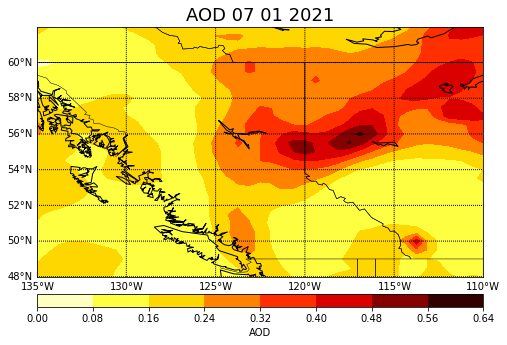

In [10]:
fig = plt.figure(figsize=(8, 8))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210701.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]

# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="cyl",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-110.,urcrnrlat=62., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon-180,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

#aod = map.contourf(x,y,np.squeeze(aodana[4,:,:]))

#cs = map.contourf(x,y,aodana[4,:,:], cmap = 'hot_r')

aod_mask_1 = np.ma.masked_greater(aodana,1.0)
aod_mask_2 = np.ma.masked_less(aod_mask_1,0)

cs = map.contourf(x,y,aod_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(cs, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='AOD', alpha = 0.8)
# cbar.set_label(tmax_units)

date = nc.AODANA.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('AOD {} {} {}'.format(month, day, year), fontsize = 18)
plt.savefig("AOD {}".format(date), dpi = 200)


## Turn Merra netcdf into csv 

In [11]:
# AODANA : Aerosol Optical Depth Analysis
ds =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')

time = ds.AODANA.time
time_array = time[1]
time_array
# scan_start = datetime.strptime(time_array, '%Y-%m-%dT%H:%M:%S.%fZ')


<xarray.DataArray 'time' ()>
array('2021-06-15T03:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-06-15T03:00:00
Attributes:
    long_name:       time
    time_increment:  30000
    begin_date:      20210615
    begin_time:      0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [12]:
# if I can load in BT as one data frame, then can just do this process once to compare 
#ds_latlon = calc_latlon(xarray.open_dataset('/data2/edworak/data/BT_nosmoke_combined/ds_21.nc'))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')

#select by lat/lon region
lat_min, lat_max = 45, 60
lon_min, lon_max = -130, -100

lat_condition = (nc.AODANA.lat >= lat_min) & (nc.AODANA.lat <= lat_max)
lon_condition = (nc.AODANA.lon >= lon_min) & (nc.AODANA.lon <= lon_max)

selected_region = nc.where((lat_condition) & (lon_condition), drop=True)

#select CMI_C14 channel anc convert into celsius
aodana = selected_region['AODANA'][4,:,:]
#print(aodana.lat[:]) 

# Convert the xarray dataarray to a pandas dataframe
df = aodana.to_dataframe()

date = aodana.time.begin_date

df['year'] = str(date)[:4]
df['month'] = str(date)[4:6]
df['day'] = str(date)[-2:]

# df["lat"] = pd.Series(aodana.lat[:])
# df["lon"] = pd.Series(aodana.lon[:])

data = df.loc[:, ("year","month", "day", "AODANA")]

# data = {'year': df["year"], 'month': df["month"], 'day': df['day'], 
#         'lat' : df["lats"], "lon" : df["lons"], "aod" : aodana}

data.reset_index
data.dropna(inplace = True)

data
data.to_csv('/data2/edworak/data/tester_merra.nc')


In [13]:
tester_merra = pd.read_csv('/data2/edworak/data/tester_merra.nc', usecols = ["year", "month", "day", "lat", "lon", "AODANA"])
tester_merra

,lat,lon,year,month,day,AODANA
0,45.0,-130.000,2021,6,15,0.128609
1,45.0,-129.375,2021,6,15,0.143267
2,45.0,-128.750,2021,6,15,0.130872
3,45.0,-128.125,2021,6,15,0.106506
4,45.0,-127.500,2021,6,15,0.087417
...,...,...,...,...,...,...
1514,60.0,-102.500,2021,6,15,0.215908
1515,60.0,-101.875,2021,6,15,0.234603
1516,60.0,-101.250,2021,6,15,0.242784
1517,60.0,-100.625,2021,6,15,0.224178


## compare AOD and lightning BT datasets

In [14]:
tester_merra = pd.read_csv('/data2/edworak/data/tester_merra.nc', usecols = ["year", "month", "day", "lat", "lon", "AODANA"])
#tester_merra = df[["year", "month", "day","AODANA"]]
tester_merra

#tester_merra.lat

,lat,lon,year,month,day,AODANA
0,45.0,-130.000,2021,6,15,0.128609
1,45.0,-129.375,2021,6,15,0.143267
2,45.0,-128.750,2021,6,15,0.130872
3,45.0,-128.125,2021,6,15,0.106506
4,45.0,-127.500,2021,6,15,0.087417
...,...,...,...,...,...,...
1514,60.0,-102.500,2021,6,15,0.215908
1515,60.0,-101.875,2021,6,15,0.234603
1516,60.0,-101.250,2021,6,15,0.242784
1517,60.0,-100.625,2021,6,15,0.224178


In [16]:
#members = lightning 

lt_nosmoke = pd.read_csv("/data2/edworak/data/lightning_df_nosmoke.csv", sep='\t')
lt_nosmoke = lt_nosmoke.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')
lt_nosmoke.reindex()
lt_nosmoke
#lt_nosmoke.l_lat

,Unnamed: 0,year,month,day,hour,minute,second,l_lat,l_lon,peak-current,C or G,CMI_C14,bt_lat,bt_lon,distance(km)
0,48,2021,6,15,18,5,1.924783,53.5947,-114.0116,125.2,G,-55.103867,53.612045,-114.015620,1.947
1,126,2021,6,15,18,5,2.096512,53.6018,-113.9254,-10.0,G,-58.036560,53.617190,-113.939210,1.939
3,176,2021,6,15,18,5,2.429782,53.6571,-114.0325,-39.8,G,-54.146255,53.651413,-114.026870,0.733
4,252,2021,6,15,18,5,2.486228,53.6266,-114.2350,-22.1,G,-56.360733,53.683445,-114.152504,8.337
6,327,2021,6,15,18,5,5.382116,53.9393,-113.5184,-13.6,G,-56.659990,53.924763,-113.517880,1.617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20853,14838,2021,6,15,23,59,48.000000,59.2990,-115.3530,-15.8,G,-57.019090,59.314545,-115.367620,1.917
20854,14887,2021,6,15,23,59,49.000000,59.3110,-115.2900,7.0,C,-58.694916,59.320705,-115.278336,1.266
20855,14927,2021,6,15,23,59,54.000000,59.3270,-115.1040,6.1,C,-60.251038,59.332714,-115.099770,0.679
20857,14945,2021,6,15,23,59,55.000000,53.6360,-115.8750,11.8,C,-36.071335,53.622547,-115.854290,2.025


In [17]:
# To make sure that there are no null values and All are either integers/ Float values 
lt_nosmoke.info() 
print('\n XXXXXXXXXXXXXXXXXXXXXXX\n')
tester_merra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13167 entries, 0 to 20858
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    13167 non-null  int64  
 1   year          13167 non-null  int64  
 2   month         13167 non-null  int64  
 3   day           13167 non-null  int64  
 4   hour          13167 non-null  int64  
 5   minute        13167 non-null  int64  
 6   second        13167 non-null  float64
 7   l_lat         13167 non-null  float64
 8   l_lon         13167 non-null  float64
 9   peak-current  13167 non-null  float64
 10  C or G        13167 non-null  object 
 11  CMI_C14       13167 non-null  float64
 12  bt_lat        13167 non-null  float64
 13  bt_lon        13167 non-null  float64
 14  distance(km)  13167 non-null  float64
dtypes: float64(8), int64(6), object(1)
memory usage: 1.6+ MB

 XXXXXXXXXXXXXXXXXXXXXXX

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 15

In [18]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [19]:
# find closest brightness temp point 
def find_nearest_merra(lat, long):

    distances = tester_merra.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return tester_merra.loc[distances.idxmin(), "AODANA"]
# get the bt from the bt_df

#then apply it to lightning 

In [20]:
lt_nosmoke['AODANA'] = lt_nosmoke.apply(
    lambda row: find_nearest_merra(row['l_lat'], row['l_lon']), 
    axis=1)
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
lt_nosmoke.head()

ValueError: not enough values to unpack (expected 4, got 2)